In [1]:
# !pip3 install torch torchvision torchaudio
# !pip install transformers
# !pip install matplotlib
# !pip install tensorflow --user
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install seaborn
# !pip install datasets

In [2]:
GLOVE_PATH = "/Users/anoushkanahata/Desktop/SC4002/SC4002_NLP/glove.6B.100d.txt" # change to your path
GLOVE_PATH = "./glove.6B.100d.txt"
EMBED_DIM = 100 # No need to change

In [3]:
from transformers import get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset 
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import sys
# sys.path.append('/Users/anoushkanahata/Desktop/SC4002/SC4002_NLP')
import pandas as pd
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from Embeddings import GloveEmbedding, GloveTokenizerNoSub
import itertools
import torch
from torch.utils.data import DataLoader
from typing import Any
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import copy

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# set seeds
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(114514)

In [5]:
# import tokenizer
tokenizer_no_sub = GloveTokenizerNoSub(glove_file_path=GLOVE_PATH)
embedding = GloveEmbedding(
    glove_file_path = GLOVE_PATH, 
    trainable = False # False for part 2 to disable the Embedding training
)

In [6]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding, hidden_size, embed_size, bidirectional, num_rnn_layer, dropout_rate, layer_norm):
        super(SentimentRNN, self).__init__()
        self.embedding = embedding  # pass pretrained embedding in
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True, num_layers = num_rnn_layer, bidirectional=bidirectional, dropout = dropout_rate if num_rnn_layer > 1 else 0)
        
        # if bidirectional, the output hidden size is double
        self.hidden_size = hidden_size * 2 if bidirectional else hidden_size
        
        # MLP
        if not layer_norm:
            self.output_layer = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1),  # output dimension is 1 (sigmoid is in BCELossWithLogits, so no sigmoid here. This will get better result)
            )
        else:
            self.output_layer = nn.Sequential(
                nn.LayerNorm(self.hidden_size),
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.LayerNorm(self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1), 
            )
        
    def forward(self, input_ids, attention_mask):
        '''
        This method is designed for biLSTM/GRU/RNN. For LSTM/GRU/RNN for only one direction, just take hidden as the rnn output.
        RNN - hidden -> MLP --> outcome
        '''
        # embed the input
        embedded = self.embedding(input_ids)  # [batch_size, seq_length, embedding_dim]
        
        # feed forward
        output, hidden = self.rnn(embedded) # we don't need encoder so we only keep the output

        # make attention mask from [batch_size, seq_length] to [batch_size, seq_length, 1] as the same dimension as rnn
        attention_mask = attention_mask.unsqueeze(-1)  # [batch_size, seq_length, 1]

        # use attention mask to mask the output, ignore the padding embedding vector, only add the valid embedding vector 
        masked_output = output * attention_mask

        # sum up all the valid output
        summed_output = masked_output.sum(dim=1)  # [batch_size, hidden_size]

        logits = self.output_layer(summed_output)
        
        return logits  # The output is [batch_size, 1]




In [7]:
# import datasets

train_df = pd.read_csv("./preprocessed_dataset/train.csv").iloc[:,1:]
validation_df = pd.read_csv("./preprocessed_dataset/validation.csv").iloc[:,1:]
test_df = pd.read_csv("./preprocessed_dataset/test.csv").iloc[:,1:]

In [8]:
# try to use tokenizer api
tokenizer_no_sub.encode(["hello world", "how are you"], return_tensors = "pt") # insist to return pytorch


{'input_ids': tensor([[13077,    87,     0],
         [  199,    34,    83]]),
 'attention_mask': tensor([[1, 1, 0],
         [1, 1, 1]])}

In [9]:
# Hyper paramaters
dropout_rate = 0.1
num_rnn_layer = 1
hidden_dim = 256

val_steps = 100 # compute validation error every n step

num_train_epochs = 3

batch_size = 32
lr = 8e-5
weight_decay = 1e-5


warmup_ratio=0.1
max_grad_norm = 2.0

In [10]:
# define dataset and data loader
class CustomizeDataset(Dataset):
    def __init__(
            self,
            df : pd.DataFrame
        ) -> None:
        super().__init__()
        self.df = df
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(
            self, 
            index : int
        ) -> dict:
        
        inputs = self.df.iloc[index,0] # 0 is text
        label = self.df.iloc[index, 1] # 1 is label
        
        return {
            "input_str" : inputs, # output a string
            "label" : label # output a label
        }
        
# collater function (used for dynamic padding to save memory)
class Collater:
    def __init__(
            self,
            tokenizer_no_sub : GloveTokenizerNoSub
        ) -> None:
        self.tokenizer_no_sub = tokenizer_no_sub 
    
    def __call__(
            self,
            instances : list # a list of string
        ) -> Any:
        # __call__ is for function-like object
        input_str_list = [instance["input_str"] for instance in instances]
        input_dict = tokenizer_no_sub.encode(input_str_list, return_tensors = "pt") # return pytorch tensor
        input_ids = input_dict["input_ids"]
        attention_mask = input_dict["attention_mask"]
        label = [torch.tensor(instance["label"], dtype = torch.int64) for instance in instances]

        return {
            "input_ids": input_ids,
            "label": torch.tensor(label),
            "attention_mask": attention_mask # mask the pad position
        }

In [11]:
# create dataset and data loader
collate_fn = Collater(tokenizer_no_sub)



train_ds = CustomizeDataset(
    df = train_df
)

train_loader = DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    collate_fn = collate_fn,
    shuffle = True
)

val_ds = CustomizeDataset(
    df = validation_df
)

val_loader = DataLoader(
    dataset = val_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

test_ds = CustomizeDataset(
    df = test_df
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

In [12]:
# compute warmup status
num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:801, warm up: 80


In [13]:
# Set optimizer, loss_fn and so on

cls_model = SentimentRNN(
    embedding = embedding, 
    hidden_size = hidden_dim, 
    embed_size = EMBED_DIM, 
    bidirectional = False, #  False for part 2
    num_rnn_layer = num_rnn_layer,
    dropout_rate = dropout_rate,
    layer_norm = True # set if you need layer norm
)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = AdamW(
    params = cls_model.parameters(),
    lr = lr,
    weight_decay = weight_decay
)

scheduler  = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps = num_training_steps
)

In [14]:
# compute accuracy for wach data loader

def compute_accuracy(data_loader: DataLoader) -> float:
    
    cls_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

def compute_loss(data_loader: DataLoader) -> float:
    total_loss = 0
    cls_model.eval()
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model.forward(input_ids, attention_mask)
            loss = loss_fn.forward(
                input = logits,
                target = labels
            )
            
            total_loss += loss.detach().cpu()
            
        total_loss /= len(val_loader)
        
        return total_loss

In [15]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance, counter):
    positive_diff = abs(validation_loss - train_loss)

    # Increment counter if no significant improvement
    if positive_diff >= min_delta:
        counter += 1
        if counter >= tolerance:
            return True, counter
    # Ensure the function always returns both values
    return False, counter

In [16]:
# Training loop

cls_model.to(device)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

counter = 0

for epoch in range(num_train_epochs):
    
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()

        # Gradient clip (important for RNN, not necessary for LSTM/GRU/conv1d)
        torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss = loss.detach().cpu()
        
        print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
        
        
        train_losses.append(vis_loss)
        i =0 

        if (step + 1) % val_steps == 0 or step == 0:
            # compute validation every "val_steps"
           
            cls_model.eval()
            val_loss = compute_loss(val_loader)
            val_acc = compute_accuracy(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            print(f"[{step + 1}/{num_training_steps}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
            # Apply early stopping
            should_stop, counter = early_stopping(vis_loss, val_loss, min_delta=0.01, tolerance=2, counter=counter)
            if should_stop:
                print("Early stopping triggered.")
                break
        
        step += 1
        
    if should_stop:
        break  # Exit e


[1/801] train loss: [0.7338] (epoch [1/3])
[1/801] validation loss: [0.7005] validation accuracy: [0.4981]
[2/801] train loss: [0.7387] (epoch [1/3])
[3/801] train loss: [0.7350] (epoch [1/3])
[4/801] train loss: [0.7270] (epoch [1/3])
[5/801] train loss: [0.7024] (epoch [1/3])
[6/801] train loss: [0.7457] (epoch [1/3])
[7/801] train loss: [0.6884] (epoch [1/3])
[8/801] train loss: [0.7260] (epoch [1/3])
[9/801] train loss: [0.6645] (epoch [1/3])
[10/801] train loss: [0.7335] (epoch [1/3])
[11/801] train loss: [0.6870] (epoch [1/3])
[12/801] train loss: [0.6733] (epoch [1/3])
[13/801] train loss: [0.7197] (epoch [1/3])
[14/801] train loss: [0.7066] (epoch [1/3])
[15/801] train loss: [0.6882] (epoch [1/3])
[16/801] train loss: [0.6948] (epoch [1/3])
[17/801] train loss: [0.7176] (epoch [1/3])
[18/801] train loss: [0.6886] (epoch [1/3])
[19/801] train loss: [0.6960] (epoch [1/3])
[20/801] train loss: [0.6967] (epoch [1/3])
[21/801] train loss: [0.6739] (epoch [1/3])
[22/801] train loss: 

In [17]:
# Test the model
# Define hyperparameter ranges
param_grid = {
    "num_rnn_layer": range(1, 2),  # Integer range for number of RNN layers
    "hidden_dim": [128, 256],  # Integer range for hidden dimension size
    "dropout_rate": [0.1, 0.2],  # Continuous range for dropout rate
    "learning_rate": [1e-4, 1e-3],  # Continuous range for learning rate
    "batch_size": [128, 256],  # Integer range for batch size
    "max_grad_norm": [1.0, 2.0],  # Continuous range for gradient clipping
    "num_train_epochs": [1,2,3]  # Integer range for number of training epochs
}

# Track the best configuration
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_params = None

# Generate all combinations of hyperparameters
for params in itertools.product(
    param_grid["num_rnn_layer"],
    param_grid["hidden_dim"],
    param_grid["dropout_rate"],
    param_grid["learning_rate"],
    param_grid["batch_size"],
    param_grid["max_grad_norm"],
    param_grid["num_train_epochs"]
):
    # Unpack hyperparameters
    num_rnn_layer, hidden_dim, dropout_rate, learning_rate, batch_size, max_grad_norm, num_train_epochs = params
    
    # Initialize model with current parameters
    cls_model = SentimentRNN(
        embedding=embedding,
        hidden_size=hidden_dim,
        embed_size=EMBED_DIM,
        bidirectional=False,
        num_rnn_layer=num_rnn_layer,
        dropout_rate=dropout_rate,
        layer_norm=True
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = torch.optim.Adam(cls_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    # DataLoader for selected batch size
    train_loader = DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=True
    )
    
    # Early stopping and metrics tracking variables
    counter = 0
    step = 0
    train_losses = []
    val_losses = []
    val_accs = []
    should_stop = False
    early_stopped = False  # Flag to indicate early stopping for this trial
    
    for epoch in range(num_train_epochs):
        # Training loop
        for data in train_loader:
            cls_model.train()
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            label = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask)
            
            loss = loss_fn(input=logits, target=label)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            vis_loss = loss.detach().cpu().item()
            train_losses.append(vis_loss)
            
            # Validation step every `val_steps`
            if (step + 1) % val_steps == 0 or step == 0:
                cls_model.eval()
                val_loss = compute_loss(val_loader)
                val_acc = compute_accuracy(val_loader)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                
                # Early stopping check
                should_stop, counter = early_stopping(vis_loss, val_loss, min_delta=0.5, tolerance=2, counter=counter)
                if should_stop:
                    print("Early stopping triggered.")
                    early_stopped = True  # Mark this trial as early stopped
                    break

            step += 1
        
        if should_stop:
            break  # Exit epoch loop if early stopping is triggered

    # Track the best parameters and validation loss
    current_val_loss = val_losses[-1] if val_losses else float('inf')
    current_val_accuracy = val_accs[-1] if val_accs else 0.0
    if current_val_accuracy > best_val_accuracy and early_stopped==False:
        best_val_loss = current_val_loss
        best_val_accuracy = current_val_accuracy
        best_params = params
    
    # Print the trial's results, including early stopping info
    print(f"Trial with params: {params}")
    print(f"  Validation Loss: {current_val_loss}")
    print(f"  Validation Accuracy: {current_val_accuracy}")
    if early_stopped:
        print("  Early stopped")
    

# Print the best result
print("Best result:")
print(f"  Validation Loss: {best_val_loss}")
print(f"  Validation Accuracy: {best_val_accuracy}")
print("  Best hyperparameters:", best_params)



Trial with params: (1, 128, 0.1, 0.0001, 128, 1.0, 1)
  Validation Loss: 0.7194907665252686
  Validation Accuracy: 0.5
Trial with params: (1, 128, 0.1, 0.0001, 128, 1.0, 2)
  Validation Loss: 0.6794100403785706
  Validation Accuracy: 0.5806754221388368
Trial with params: (1, 128, 0.1, 0.0001, 128, 1.0, 3)
  Validation Loss: 0.6822980046272278
  Validation Accuracy: 0.574108818011257
Trial with params: (1, 128, 0.1, 0.0001, 128, 2.0, 1)
  Validation Loss: 0.6995674967765808
  Validation Accuracy: 0.5131332082551595
Trial with params: (1, 128, 0.1, 0.0001, 128, 2.0, 2)
  Validation Loss: 0.6873984336853027
  Validation Accuracy: 0.573170731707317
Trial with params: (1, 128, 0.1, 0.0001, 128, 2.0, 3)
  Validation Loss: 0.6906976699829102
  Validation Accuracy: 0.5187617260787992
Trial with params: (1, 128, 0.1, 0.0001, 256, 1.0, 1)
  Validation Loss: 0.6926606297492981
  Validation Accuracy: 0.5121951219512195
Trial with params: (1, 128, 0.1, 0.0001, 256, 1.0, 2)
  Validation Loss: 0.6973

In [18]:
## (1, 256, 0.2, 0.001, 128, 2.0, 3)--> higest accuracy
print(best_params)

(1, 256, 0.2, 0.001, 256, 1.0, 3)


In [19]:
val_steps = 100
batch_size = 128
dropout_rate = 0.2
hidden_dim = 258
learning_rate = 0.001
num_rnn_layer = 1
max_grad_norm = 2.0
num_train_epochs = 3

num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:102, warm up: 10


In [20]:
cls_model = SentimentRNN(
    embedding=embedding,
    hidden_size=hidden_dim,
    embed_size=EMBED_DIM,
    bidirectional=False,  # False for part 2
    num_rnn_layer=num_rnn_layer,
    dropout_rate=dropout_rate,
    layer_norm=True
).to(device)
# Set up optimizer and scheduler
optimizer = torch.optim.Adam(cls_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

counter = 0

for epoch in range(num_train_epochs):
    
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()

        # Gradient clip (important for RNN, not necessary for LSTM/GRU/conv1d)
        torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss = loss.detach().cpu()
        
        print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
        
        
        train_losses.append(vis_loss)
        i =0 

        if (step + 1) % val_steps == 0 or step == 0:
            # compute validation every "val_steps"
           
            cls_model.eval()
            val_loss = compute_loss(val_loader)
            val_acc = compute_accuracy(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            print(f"[{step + 1}/{num_training_steps}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
            # Apply early stopping
            should_stop, counter = early_stopping(vis_loss, val_loss, min_delta=0.5, tolerance=2, counter=counter)
            if should_stop:
                print("Early stopping triggered.")
                break
        
        step += 1
        
    if should_stop:
        break  # Exit e

[1/102] train loss: [0.6976] (epoch [1/3])
[1/102] validation loss: [1.1582] validation accuracy: [0.5009]
[2/102] train loss: [1.0857] (epoch [1/3])
[3/102] train loss: [0.8530] (epoch [1/3])
[4/102] train loss: [0.7028] (epoch [1/3])
[5/102] train loss: [0.6900] (epoch [1/3])
[6/102] train loss: [0.7248] (epoch [1/3])
[7/102] train loss: [0.7236] (epoch [1/3])
[8/102] train loss: [0.6882] (epoch [1/3])
[9/102] train loss: [0.6873] (epoch [1/3])
[10/102] train loss: [0.6870] (epoch [1/3])
[11/102] train loss: [0.6892] (epoch [1/3])
[12/102] train loss: [0.6846] (epoch [1/3])
[13/102] train loss: [0.7140] (epoch [1/3])
[14/102] train loss: [0.6715] (epoch [1/3])
[15/102] train loss: [0.6771] (epoch [1/3])
[16/102] train loss: [0.6850] (epoch [1/3])
[17/102] train loss: [0.6765] (epoch [1/3])
[18/102] train loss: [0.6770] (epoch [1/3])
[19/102] train loss: [0.6711] (epoch [1/3])
[20/102] train loss: [0.6846] (epoch [1/3])
[21/102] train loss: [0.6742] (epoch [1/3])
[22/102] train loss: 

In [21]:
train_loss = compute_loss(train_loader)
train_acc = compute_accuracy(train_loader)
test_loss = compute_loss(test_loader)
test_acc = compute_accuracy(test_loader)
val_loss = compute_loss(val_loader)
test_acc = compute_accuracy(test_loader)

print(f"Train Loss: [{train_loss:.4f}]\nTrain accuracy: [{train_acc:.4f}]")
print(f"Test Loss: [{test_loss:.4f}]\nTest accuracy: [{test_acc:.4f}]")
print(f"Validation Loss: [{val_loss:.4f}]\nValidation accuracy: [{val_acc:.4f}]")

Train Loss: [1.3063]
Train accuracy: [0.6694]
Test Loss: [0.6645]
Test accuracy: [0.6492]
Validation Loss: [0.6657]
Validation accuracy: [0.6660]


In [22]:
# compute predictions and labels for confusion matrix computing
def compute_pedictions_and_labels(
        model : nn.Module, 
        test_loader : DataLoader, 
        device : torch.device
    ) -> tuple:
    
    model.to(device)
    
    model.eval()
    
    # Lists to store all predictions and actual labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    return all_predictions, all_labels

all_predictions, all_labels = compute_pedictions_and_labels(cls_model, test_loader, device)

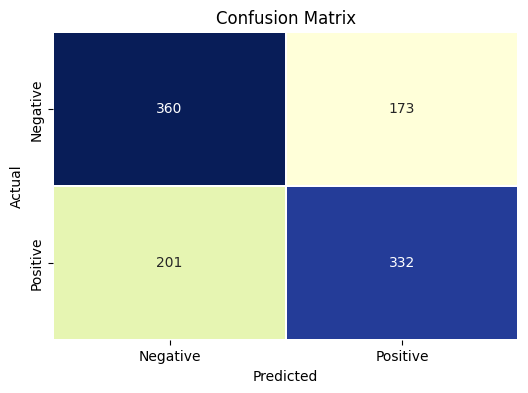

In [23]:
# visualization 2: confusion matrix

def plot_confusion(
        all_predictions : list, 
        all_labels : list
    ) -> None:      
            
    cm = confusion_matrix(all_labels, all_predictions) # from sklearn
            
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.2, cmap="YlGnBu", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
    plt.show()
    
plot_confusion(all_predictions, all_labels)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class BaseSentimentRNN(nn.Module):
    """
    Base RNN class for sentiment classification with different sentence representation methods.
    This serves as the foundation for different representation strategies.
    """
    def __init__(
        self, 
        embedding, 
        hidden_size=256, 
        embed_size=100,
        num_rnn_layer=1,
        dropout_rate=0.2,
        layer_norm=True
    ):
        super().__init__()
        self.embedding = embedding
        
        # RNN Layer
        self.rnn = nn.RNN(
            embed_size,
            hidden_size,
            batch_first=True,
            num_layers=num_rnn_layer,
            dropout=dropout_rate if num_rnn_layer > 1 else 0
        )
        
        # Output layers with layer normalization option
        if layer_norm:
            self.output_layer = nn.Sequential(
                nn.LayerNorm(hidden_size),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, hidden_size),
                nn.LayerNorm(hidden_size),
                nn.GELU(),
                nn.Linear(hidden_size, 1)
            )
        else:
            self.output_layer = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.Linear(hidden_size, 1)
            )

    def forward(self, input_ids, attention_mask):
        raise NotImplementedError("Each representation method must implement its own forward pass")

class LastHiddenStateRNN(BaseSentimentRNN):
    """
    Uses the last hidden state of the RNN as sentence representation.
    Theoretical justification: The last hidden state contains information about the entire sequence
    with more emphasis on recent tokens, which can be beneficial for sentiment analysis.
    """
    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        output, _ = self.rnn(embedded)
        
        # Get the last non-padded position for each sequence
        last_positions = attention_mask.sum(1) - 1
        batch_size = output.size(0)
        
        # Select the last hidden state for each sequence
        last_hidden = output[torch.arange(batch_size), last_positions]
        return self.output_layer(last_hidden)

class MeanPoolingRNN(BaseSentimentRNN):
    """
    Uses mean pooling over all hidden states as sentence representation.
    Theoretical justification: Averaging all hidden states gives equal importance to all words,
    which can be beneficial when sentiment is distributed throughout the sentence.
    """
    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        output, _ = self.rnn(embedded)
        
        # Apply attention mask and compute mean
        attention_mask = attention_mask.unsqueeze(-1)
        masked_output = output * attention_mask
        summed = masked_output.sum(dim=1)
        lengths = attention_mask.sum(dim=1)
        mean_pooled = summed / lengths
        
        return self.output_layer(mean_pooled)

class MaxPoolingRNN(BaseSentimentRNN):
    """
    Uses max pooling over all hidden states as sentence representation.
    Theoretical justification: Max pooling captures the most salient features from each dimension,
    which can be effective for detecting strong sentiment signals regardless of position.
    """
    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        output, _ = self.rnn(embedded)
        
        # Apply attention mask and compute max
        attention_mask = attention_mask.unsqueeze(-1)
        masked_output = output * attention_mask
        max_pooled = torch.max(masked_output, dim=1)[0]
        
        return self.output_layer(max_pooled)

class AttentionRNN(BaseSentimentRNN):
    """
    Uses attention mechanism to weight different hidden states.
    Theoretical justification: Attention allows the model to focus on the most relevant parts
    of the sentence for sentiment classification, learning which words are more important.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attention = nn.Linear(kwargs.get('hidden_size', 256), 1)
    
    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        output, _ = self.rnn(embedded)
        
        # Compute attention weights
        attention_weights = self.attention(output)
        attention_weights = attention_weights.squeeze(-1)
        
        # Mask padding tokens
        attention_weights = attention_weights.masked_fill(~attention_mask.bool(), float('-inf'))
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # Apply attention weights
        attention_weights = attention_weights.unsqueeze(-1)
        weighted_sum = (output * attention_weights).sum(dim=1)
        
        return self.output_layer(weighted_sum)

In [46]:
class SentimentModelEvaluator:
    def __init__(
        self,
        embedding,
        device,
        train_loader,
        val_loader,
        test_loader,
        config
    ):
        self.embedding = embedding
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.config = config
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.results = {}

    def train_model(self, model_class, model_name):
        """
        Trains a single model with the specified configuration
        """
        print(f"\nTraining {model_name} Model...")
        
        # Initialize model
        model = model_class(
            embedding=self.embedding,
            hidden_size=self.config['hidden_size'],
            embed_size=self.config['embed_size'],
            num_rnn_layer=self.config['num_rnn_layer'],
            dropout_rate=self.config['dropout_rate'],
            layer_norm=self.config['layer_norm']
        ).to(self.device)
        
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=self.config['learning_rate']
        )
        
        best_val_acc = 0
        best_model_state = None
        train_losses = []
        val_accuracies = []
        
        for epoch in range(self.config['num_train_epochs']):
            model.train()
            epoch_losses = []
            
            for step, batch in enumerate(self.train_loader):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].view(-1, 1).float().to(self.device)
                
                logits = model(input_ids, attention_mask)
                loss = self.loss_fn(logits, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(),
                    self.config['max_grad_norm']
                )
                
                optimizer.step()
                optimizer.zero_grad()
                
                epoch_losses.append(loss.item())
                
                if (step + 1) % self.config['val_steps'] == 0:
                    val_acc = self.compute_accuracy(model, self.val_loader)
                    val_accuracies.append(val_acc)
                    print(f"Epoch {epoch+1}, Step {step+1}, Val Acc: {val_acc:.4f}")
                    
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_model_state = copy.deepcopy(model.state_dict())
            
            avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            train_losses.append(avg_epoch_loss)
            
            # Compute validation accuracy at the end of each epoch
            current_val_acc = self.compute_accuracy(model, self.val_loader)
            print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}, Validation Accuracy: {current_val_acc:.4f}")
            
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_model_state = copy.deepcopy(model.state_dict())
        
        # Load the best model state for final evaluation
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        # Compute final accuracies
        final_val_acc = self.compute_accuracy(model, self.val_loader)
        test_acc = self.compute_accuracy(model, self.test_loader)
        print(f"{model_name} Final Results:")
        print(f"Best Validation Accuracy: {best_val_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        # Store results
        self.results[model_name] = {
            'model_state': best_model_state,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': best_val_acc,
            'final_val_acc': final_val_acc,
            'test_acc': test_acc
        }
        
        return model, test_acc

    def compute_accuracy(self, model, data_loader):
        """
        Computes accuracy for the given model and data loader
        """
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].view(-1, 1).float().to(self.device)
                
                logits = model(input_ids, attention_mask)
                predictions = (logits > 0).long()
                
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        return correct / total

    def evaluate_all_methods(self):
        """
        Evaluates all sentence representation methods
        """
        models = {
            'Last Hidden State': LastHiddenStateRNN,
            'Mean Pooling': MeanPoolingRNN,
            'Max Pooling': MaxPoolingRNN,
            'Attention': AttentionRNN
        }
        
        for name, model_class in models.items():
            _, test_acc = self.train_model(model_class, name)

    def print_comparative_results(self):
        """
        Prints comparative results of all methods
        """
        print("\nComparative Results:")
        print("-" * 70)
        print(f"{'Method':<20} {'Test Accuracy':<15} {'Best Val Accuracy':<15} {'Final Val Accuracy':<15}")
        print("-" * 70)
        
        for method, results in self.results.items():
            print(f"{method:<20} {results['test_acc']:.4f} {results['best_val_acc']:.4f} {results['final_val_acc']:.4f}")

In [47]:
# Configuration dictionary
config = {
    'hidden_size': 256,
    'embed_size': 100,
    'num_rnn_layer': 1,
    'dropout_rate': 0.2,
    'layer_norm': True,
    'learning_rate': 0.001,
    'batch_size': 128,
    'max_grad_norm': 2.0,
    'num_train_epochs': 3,
    'val_steps': 100
}

evaluator = SentimentModelEvaluator(
    embedding=embedding,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    config=config
)

# Run evaluation for all methods
evaluator.evaluate_all_methods()

# Print comparative results
evaluator.print_comparative_results()


Training Last Hidden State Model...
Epoch 1 Average Loss: 0.6707, Validation Accuracy: 0.6388
Epoch 2 Average Loss: 0.5962, Validation Accuracy: 0.6895
Epoch 3 Average Loss: 0.5719, Validation Accuracy: 0.7270
Last Hidden State Final Results:
Best Validation Accuracy: 0.7270
Test Accuracy: 0.7167

Training Mean Pooling Model...
Epoch 1 Average Loss: 0.6117, Validation Accuracy: 0.7186
Epoch 2 Average Loss: 0.5549, Validation Accuracy: 0.7251
Epoch 3 Average Loss: 0.5432, Validation Accuracy: 0.7064
Mean Pooling Final Results:
Best Validation Accuracy: 0.7251
Test Accuracy: 0.7280

Training Max Pooling Model...
Epoch 1 Average Loss: 0.6008, Validation Accuracy: 0.6998
Epoch 2 Average Loss: 0.4809, Validation Accuracy: 0.7514
Epoch 3 Average Loss: 0.4092, Validation Accuracy: 0.7514
Max Pooling Final Results:
Best Validation Accuracy: 0.7514
Test Accuracy: 0.7608

Training Attention Model...
Epoch 1 Average Loss: 0.6020, Validation Accuracy: 0.7336
Epoch 2 Average Loss: 0.5120, Validati

# Question 2c: Methods for Deriving Sentence Representations

We implemented and compared four different methods for deriving sentence representations from RNN outputs. Each method offers a unique approach to aggregating the hidden states into a meaningful sentence vector.

## Implementation Results

| Method | Test Accuracy | Validation Accuracy |
|--------|---------------|-------------------|
| Last Hidden State | 71.67% | 72.70% |
| Mean Pooling | 72.80% | 72.51% |
| Max Pooling | 76.08% | 75.14% |
| Attention | 74.48% | 77.02% |

## Method Analysis

### 1. Last Hidden State (71.67%)
- **Implementation**: Uses the final RNN state as the sentence representation
- **Performance**: Baseline performance, lowest accuracy among all methods
- **Limitation**: May lose important information from earlier parts of the sentence

### 2. Mean Pooling (72.80%)
- **Implementation**: Averages all hidden states across the sequence
- **Performance**: Shows improved performance over last hidden state
- **Characteristic**: Effectively captures overall sentiment but may dilute strong signals

### 3. Max Pooling (76.08%)
- **Implementation**: Takes maximum values across all hidden states
- **Performance**: Achieves the best test performance
- **Strength**: Successfully captures the most salient features for sentiment classification
- **Advantage**: Particularly effective at identifying strong sentiment indicators regardless of position

### 4. Attention Mechanism (74.48%)
- **Implementation**: Uses learned attention weights to create weighted sum of hidden states
- **Performance**: Shows second-best test performance
- **Notable**: Demonstrates highest validation accuracy (77.02%)
- **Observation**: Slight performance gap between validation and test suggests potential overfitting

## Key Findings

1. **Best Method**: Max Pooling emerged as the most effective method, suggesting that capturing the strongest sentiment signals is more important than position-based or averaged representations

2. **Method Comparison**: All advanced pooling methods outperformed the basic last hidden state approach

3. **Future Improvement**: The attention mechanism shows promise but may benefit from additional regularisation to reduce the validation-test accuracy gap